The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Deep Convolutional Neural Networks (AlexNet)
:label:`sec_alexnet`


Although convolutional neural networks were well known
in the computer vision and machine learning communities
following the introduction of LeNet,
they did not immediately dominate the field.
Although LeNet achieved good results on early small datasets,
the performance and feasibility of training convolutional networks
on larger, more realistic datasets had yet to be established.
In fact, for much of the intervening time between the early 1990s
and the watershed results of 2012,
neural networks were often surpassed by other machine learning methods,
such as support vector machines.


For computer vision, this comparison is perhaps not fair.
That is although the inputs to convolutional networks
consist of raw or lightly-processed (e.g., by centering) pixel values, practitioners would never feed raw pixels into traditional models.
Instead, typical computer vision pipelines
consisted of manually engineering feature extraction pipelines.
Rather than *learn the features*, the features were *crafted*.
Most of the progress came from having more clever ideas for features,
and the learning algorithm was often relegated to an afterthought.

Although some neural network accelerators were available in the 1990s,
they were not yet sufficiently powerful to make
deep multichannel, multilayer convolutional neural networks
with a large number of parameters.
Moreover, datasets were still relatively small.
Added to these obstacles, key tricks for training neural networks
including parameter initialization heuristics,
clever variants of stochastic gradient descent,
non-squashing activation functions,
and effective regularization techniques were still missing.

Thus, rather than training *end-to-end* (pixel to classification) systems,
classical pipelines looked more like this:

1. Obtain an interesting dataset. In early days, these datasets required expensive sensors (at the time, 1 megapixel images were state of the art).
2. Preprocess the dataset with hand-crafted features based on some knowledge of optics, geometry, other analytic tools, and occasionally on the serendipitous discoveries of lucky graduate students.
3. Feed the data through a standard set of feature extractors such as [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform), the Scale-Invariant Feature Transform, or [SURF](https://en.wikipedia.org/wiki/Speeded_up_robust_features), the Speeded-Up Robust Features, or any number of other hand-tuned pipelines.
4. Dump the resulting representations into your favorite classifier, likely a linear model or kernel method, to train a classifier.

If you spoke to machine learning researchers,
they believed that machine learning was both important and beautiful.
Elegant theories proved the properties of various classifiers.
The field of machine learning was thriving, rigorous and eminently useful. However, if you spoke to a computer vision researcher,
you’d hear a very different story.
The dirty truth of image recognition, they’d tell you,
is that features, not learning algorithms, drove progress.
Computer vision researchers justifiably believed
that a slightly bigger or cleaner dataset
or a slightly improved feature-extraction pipeline
mattered far more to the final accuracy than any learning algorithm.


## Learning Feature Representation

Another way to cast the state of affairs is that
the most important part of the pipeline was the representation.
And up until 2012 the representation was calculated mechanically.
In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper.
[SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform),
[SURF](https://en.wikipedia.org/wiki/Speeded_up_robust_features),
[HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients),
[Bags of visual words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)
and similar feature extractors ruled the roost.

Another group of researchers,
including Yann LeCun, Geoff Hinton, Yoshua Bengio,
Andrew Ng, Shun-ichi Amari, and Juergen Schmidhuber,
had different plans.
They believed that features themselves ought to be learned.
Moreover, they believed that to be reasonably complex,
the features ought to be hierarchically composed
with multiple jointly learned layers, each with learnable parameters.
In the case of an image, the lowest layers might come
to detect edges, colors, and textures.
Indeed, :cite:`Krizhevsky.Sutskever.Hinton.2012` proposed a new variant of a convolutional neural network
which achieved excellent performance in the ImageNet challenge.

Interestingly in the lowest layers of the network,
the model learned feature extractors that resembled some traditional filters.
:numref:`fig_filters` is reproduced from this paper
and describes lower-level image descriptors.

![Image filters learned by the first layer of AlexNet](../img/filters.png)
:width:`400px`
:label:`fig_filters`

Higher layers in the network might build upon these representations
to represent larger structures, like eyes, noses, blades of grass, etc.
Even higher layers might represent whole objects
like people, airplanes, dogs, or frisbees.
Ultimately, the final hidden state learns a compact representation
of the image that summarizes its contents
such that data belonging to different categories be separated easily.


While the ultimate breakthrough for many-layered convolutional networks
came in 2012, a core group of researchers had dedicated themselves
to this idea, attempting to learn hierarchical representations of visual data
for many years.
The ultimate breakthrough in 2012 can be attributed to two key factors.

### Missing Ingredient - Data

Deep models with many layers require large amounts of data
in order to enter the regime
where they significantly outperform traditional methods
based on convex optimizations (e.g., linear and kernel methods).
However, given the limited storage capacity of computers,
the relative expense of sensors,
and the comparatively tighter research budgets in the 1990s,
most research relied on tiny datasets.
Numerous papers addressed the UCI collection of datasets,
many of which contained only hundreds or (a few) thousands of images
captured in unnatural settings with low resolution.

In 2009, the ImageNet dataset was released,
challenging researchers to learn models from 1 million examples,
1,000 each from 1,000 distinct categories of objects.
The researchers, led by Fei-Fei Li, who introduced this dataset
leveraged Google Image Search to prefilter large candidate sets
for each category and employed
the Amazon Mechanical Turk crowdsourcing pipeline
to confirm for each image whether it belonged to the associated category.
This scale was unprecedented.
The associated competition, dubbed the ImageNet Challenge
pushed computer vision and machine learning research forward,
challenging researchers to identify which models performed best
at a greater scale than academics had previously considered.


### Missing Ingredient - Hardware

Deep learning models are voracious consumers of compute cycles.
Training can take hundreds of epochs, and each iteration
requires passing data through many layers of computationally-expensive
linear algebra operations.
This is one of the main reasons why in the 90s and early 2000s,
simple algorithms based on the more-efficiently optimized
convex objectives were preferred.

Graphical processing units (GPUs) proved to be a game changer
in make deep learning feasible.
These chips had long been developed for accelerating
graphics processing to benefit computer games.
In particular, they were optimized for high throughput 4x4 matrix-vector products, which are needed for many computer graphics tasks.
Fortunately, this math is strikingly similar
to that required to calculate convolutional layers.
Around that time, NVIDIA and ATI had begun optimizing GPUs
for general compute operations,
going as far as to market them as General Purpose GPUs (GPGPU).

To provide some intuition, consider the cores of a modern microprocessor
(CPU).
Each of the cores is fairly powerful running at a high clock frequency
and sporting large caches (up to several MB of L3).
Each core is well-suited to executing a wide range of instructions,
with branch predictors, a deep pipeline, and other bells and whistles
that enable it to run a large variety of programs.
This apparent strength, however, is also its Achilles heel:
general purpose cores are very expensive to build.
They require lots of chip area,
a sophisticated support structure
(memory interfaces, caching logic between cores,
high speed interconnects, etc.),
and they are comparatively bad at any single task.
Modern laptops have up to 4 cores,
and even high end servers rarely exceed 64 cores,
simply because it is not cost effective.

By comparison, GPUs consist of 100-1000 small processing elements
(the details differ somewhat between NVIDIA, ATI, ARM and other chip vendors),
often grouped into larger groups (NVIDIA calls them warps).
While each core is relatively weak,
sometimes even running at sub-1GHz clock frequency,
it is the total number of such cores that makes GPUs orders of magnitude faster than CPUs.
For instance, NVIDIA's latest Volta generation offers up to 120 TFlops per chip for specialized instructions
(and up to 24 TFlops for more general purpose ones),
while floating point performance of CPUs has not exceeded 1 TFlop to date.
The reason for why this is possible is actually quite simple:
first, power consumption tends to grow *quadratically* with clock frequency.
Hence, for the power budget of a CPU core that runs 4x faster (a typical number),
you can use 16 GPU cores at 1/4 the speed,
which yields 16 x 1/4 = 4x the performance.
Furthermore, GPU cores are much simpler
(in fact, for a long time they were not even *able*
to execute general purpose code),
which makes them more energy efficient.
Last, many operations in deep learning require high memory bandwidth.
Again, GPUs shine here with buses that are at least 10x as wide as many CPUs.

Back to 2012. A major breakthrough came
when Alex Krizhevsky and Ilya Sutskever
implemented a deep convolutional neural network
that could run on GPU hardware.
They realized that the computational bottlenecks in CNNs
(convolutions and matrix multiplications)
are all operations that could be parallelized in hardware.
Using two NVIDIA GTX 580s with 3GB of memory,
they implemented fast convolutions.
The code [cuda-convnet](https://code.google.com/archive/p/cuda-convnet/)
was good enough that for several years
it was the industry standard and powered
the first couple years of the deep learning boom.

## AlexNet

AlexNet was introduced in 2012, named after Alex Krizhevsky,
the first author of the breakthrough ImageNet classification paper :cite:`Krizhevsky.Sutskever.Hinton.2012`. AlexNet, which employed an 8-layer convolutional neural network,
won the ImageNet Large Scale Visual Recognition Challenge 2012
by a phenomenally large margin.
This network proved, for the first time,
that the features obtained by learning can transcend manually-design features, breaking the previous paradigm in computer vision.
The architectures of AlexNet and LeNet are *very similar*,
as :numref:`fig_alexnet` illustrates.
Note that we provide a slightly streamlined version of AlexNet
removing some of the design quirks that were needed in 2012
to make the model fit on two small GPUs.

![LeNet (left) and AlexNet (right)](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

The design philosophies of AlexNet and LeNet are very similar,
but there are also significant differences.
First, AlexNet is much deeper than the comparatively small LeNet5.
AlexNet consists of eight layers: five convolutional layers,
two fully-connected hidden layers, and one fully-connected output layer. Second, AlexNet used the ReLU instead of the sigmoid
as its activation function.
Let us delve into the details below.

### Architecture

In AlexNet's first layer, the convolution window shape is $11\times11$.
Since most images in ImageNet are more than ten times higher and wider
than the MNIST images,
objects in ImageNet data tend to occupy more pixels.
Consequently, a larger convolution window is needed to capture the object.
The convolution window shape in the second layer
is reduced to $5\times5$, followed by $3\times3$.
In addition, after the first, second, and fifth convolutional layers,
the network adds maximum pooling layers
with a window shape of $3\times3$ and a stride of 2.
Moreover, AlexNet has ten times more convolution channels than LeNet.

After the last convolutional layer are two fully-connected layers
with 4096 outputs.
These two huge fully-connected layers produce model parameters of nearly 1 GB.
Due to the limited memory in early GPUs,
the original AlexNet used a dual data stream design,
so that each of their two GPUs could be responsible
for storing and computing only its half of the model.
Fortunately, GPU memory is comparatively abundant now,
so we rarely need to break up models across GPUs these days
(our version of the AlexNet model deviates
from the original paper in this aspect).

### Activation Functions

Second, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function.
 On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that back propagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

### Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully-connected layer
by dropout (:numref:`sec_dropout`),
while LeNet only uses weight decay.
To augment the data even further, the training loop of AlexNet
added a great deal of image augmentation,
such as flipping, clipping, and color changes.
This makes the model more robust and the larger sample size effectively reduces overfitting.
We will discuss data augmentation in greater detail in :numref:`sec_image_augmentation`.

In [1]:
from d2l import torch as d2l
import torch
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Linear(4096, 10))

We construct a single-channel data instance with both height and width of 224 to observe the output shape of each layer. It matches our diagram above.

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Dropout Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

## Reading the Dataset

Although AlexNet uses ImageNet in the paper, we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on Fashion-MNIST
is that our images are lower resolution ($28 \times 28$ pixels)
than ImageNet images.
To make things work, we upsample them to $224 \times 224$
(generally not a smart practice,
but we do it here to be faithful to the AlexNet architecture).
We perform this resizing with the `resize` argument in `load_data_fashion_mnist`.

In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

0.0%

0.0%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.7%

38.7%

38.7%

38.8%

38.8%

38.8%

38.8%

38.9%

38.9%

38.9%

39.0%

39.0%

39.0%

39.1%

39.1%

39.1%

39.2%

39.2%

39.2%

39.3%

39.3%

39.3%

39.3%

39.4%

39.4%

39.4%

39.5%

39.5%

39.5%

39.6%

39.6%

39.6%

39.7%

39.7%

39.7%

39.7%

39.8%

39.8%

39.8%

39.9%

39.9%

39.9%

40.0%

40.0%

40.0%

40.1%

40.1%

40.1%

40.2%

40.2%

40.2%

40.2%

40.3%

40.3%

40.3%

40.4%

40.4%

40.4%

40.5%

40.5%

40.5%

40.6%

40.6%

40.6%

40.6%

40.7%

40.7%

40.7%

40.8%

40.8%

40.8%

40.9%

40.9%

40.9%

41.0%

41.0%

41.0%

41.1%

41.1%

41.1%

41.1%

41.2%

41.2%

41.2%

41.3%

41.3%

41.3%

41.4%

41.4%

41.4%

41.5%

41.5%

41.5%

41.5%

41.6%

41.6%

41.6%

41.7%

41.7%

41.7%

41.8%

41.8%

41.8%

41.9%

41.9%

41.9%

41.9%

42.0%

42.0%

42.0%

42.1%

42.1%

42.1%

42.2%

42.2%

42.2%

42.3%

42.3%

42.3%

42.4%

42.4%

42.4%

42.4%

42.5%

42.5%

42.5%

42.6%

42.6%

42.6%

42.7%

42.7%

42.7%

42.8%

42.8%

42.8%

42.8%

42.9%

42.9%

42.9%

43.0%

43.0%

43.0%

43.1%

43.1%

43.1%

43.2%

43.2%

43.2%

43.3%

43.3%

43.3%

43.3%

43.4%

43.4%

43.4%

43.5%

43.5%

43.5%

43.6%

43.6%

43.6%

43.7%

43.7%

43.7%

43.7%

43.8%

43.8%

43.8%

43.9%

43.9%

43.9%

44.0%

44.0%

44.0%

44.1%

44.1%

44.1%

44.2%

44.2%

44.2%

44.2%

44.3%

44.3%

44.3%

44.4%

44.4%

44.4%

44.5%

44.5%

44.5%

44.6%

44.6%

44.6%

44.6%

44.7%

44.7%

44.7%

44.8%

44.8%

44.8%

44.9%

44.9%

44.9%

45.0%

45.0%

45.0%

45.0%

45.1%

45.1%

45.1%

45.2%

45.2%

45.2%

45.3%

45.3%

45.3%

45.4%

45.4%

45.4%

45.5%

45.5%

45.5%

45.5%

45.6%

45.6%

45.6%

45.7%

45.7%

45.7%

45.8%

45.8%

45.8%

45.9%

45.9%

45.9%

45.9%

46.0%

46.0%

46.0%

46.1%

46.1%

46.1%

46.2%

46.2%

46.2%

46.3%

46.3%

46.3%

46.4%

46.4%

46.4%

46.4%

46.5%

46.5%

46.5%

46.6%

46.6%

46.6%

46.7%

46.7%

46.7%

46.8%

46.8%

46.8%

46.8%

46.9%

46.9%

46.9%

47.0%

47.0%

47.0%

47.1%

47.1%

47.1%

47.2%

47.2%

47.2%

47.3%

47.3%

47.3%

47.3%

47.4%

47.4%

47.4%

47.5%

47.5%

47.5%

47.6%

47.6%

47.6%

47.7%

47.7%

47.7%

47.7%

47.8%

47.8%

47.8%

47.9%

47.9%

47.9%

48.0%

48.0%

48.0%

48.1%

48.1%

48.1%

48.2%

48.2%

48.2%

48.2%

48.3%

48.3%

48.3%

48.4%

48.4%

48.4%

48.5%

48.5%

48.5%

48.6%

48.6%

48.6%

48.6%

48.7%

48.7%

48.7%

48.8%

48.8%

48.8%

48.9%

48.9%

48.9%

49.0%

49.0%

49.0%

49.0%

49.1%

49.1%

49.1%

49.2%

49.2%

49.2%

49.3%

49.3%

49.3%

49.4%

49.4%

49.4%

49.5%

49.5%

49.5%

49.5%

49.6%

49.6%

49.6%

49.7%

49.7%

49.7%

49.8%

49.8%

49.8%

49.9%

49.9%

49.9%

49.9%

50.0%

50.0%

50.0%

50.1%

50.1%

50.1%

50.2%

50.2%

50.2%

50.3%

50.3%

50.3%

50.4%

50.4%

50.4%

50.4%

50.5%

50.5%

50.5%

50.6%

50.6%

50.6%

50.7%

50.7%

50.7%

50.8%

50.8%

50.8%

50.8%

50.9%

50.9%

50.9%

51.0%

51.0%

51.0%

51.1%

51.1%

51.1%

51.2%

51.2%

51.2%

51.3%

51.3%

51.3%

51.3%

51.4%

51.4%

51.4%

51.5%

51.5%

51.5%

51.6%

51.6%

51.6%

51.7%

51.7%

51.7%

51.7%

51.8%

51.8%

51.8%

51.9%

51.9%

51.9%

52.0%

52.0%

52.0%

52.1%

52.1%

52.1%

52.1%

52.2%

52.2%

52.2%

52.3%

52.3%

52.3%

52.4%

52.4%

52.4%

52.5%

52.5%

52.5%

52.6%

52.6%

52.6%

52.6%

52.7%

52.7%

52.7%

52.8%

52.8%

52.8%

52.9%

52.9%

52.9%

53.0%

53.0%

53.0%

53.0%

53.1%

53.1%

53.1%

53.2%

53.2%

53.2%

53.3%

53.3%

53.3%

53.4%

53.4%

53.4%

53.5%

53.5%

53.5%

53.5%

53.6%

53.6%

53.6%

53.7%

53.7%

53.7%

53.8%

53.8%

53.8%

53.9%

53.9%

53.9%

53.9%

54.0%

54.0%

54.0%

54.1%

54.1%

54.1%

54.2%

54.2%

54.2%

54.3%

54.3%

54.3%

54.4%

54.4%

54.4%

54.4%

54.5%

54.5%

54.5%

54.6%

54.6%

54.6%

54.7%

54.7%

54.7%

54.8%

54.8%

54.8%

54.8%

54.9%

54.9%

54.9%

55.0%

55.0%

55.0%

55.1%

55.1%

55.1%

55.2%

55.2%

55.2%

55.3%

55.3%

55.3%

55.3%

55.4%

55.4%

55.4%

55.5%

55.5%

55.5%

55.6%

55.6%

55.6%

55.7%

55.7%

55.7%

55.7%

55.8%

55.8%

55.8%

55.9%

55.9%

55.9%

56.0%

56.0%

56.0%

56.1%

56.1%

56.1%

56.1%

56.2%

56.2%

56.2%

56.3%

56.3%

56.3%

56.4%

56.4%

56.4%

56.5%

56.5%

56.5%

56.6%

56.6%

56.6%

56.6%

56.7%

56.7%

56.7%

56.8%

56.8%

56.8%

56.9%

56.9%

56.9%

57.0%

57.0%

57.0%

57.0%

57.1%

57.1%

57.1%

57.2%

57.2%

57.2%

57.3%

57.3%

57.3%

57.4%

57.4%

57.4%

57.5%

57.5%

57.5%

57.5%

57.6%

57.6%

57.6%

57.7%

57.7%

57.7%

57.8%

57.8%

57.8%

57.9%

57.9%

57.9%

57.9%

58.0%

58.0%

58.0%

58.1%

58.1%

58.1%

58.2%

58.2%

58.2%

58.3%

58.3%

58.3%

58.4%

58.4%

58.4%

58.4%

58.5%

58.5%

58.5%

58.6%

58.6%

58.6%

58.7%

58.7%

58.7%

58.8%

58.8%

58.8%

58.8%

58.9%

58.9%

58.9%

59.0%

59.0%

59.0%

59.1%

59.1%

59.1%

59.2%

59.2%

59.2%

59.2%

59.3%

59.3%

59.3%

59.4%

59.4%

59.4%

59.5%

59.5%

59.5%

59.6%

59.6%

59.6%

59.7%

59.7%

59.7%

59.7%

59.8%

59.8%

59.8%

59.9%

59.9%

59.9%

60.0%

60.0%

60.0%

60.1%

60.1%

60.1%

60.1%

60.2%

60.2%

60.2%

60.3%

60.3%

60.3%

60.4%

60.4%

60.4%

60.5%

60.5%

60.5%

60.6%

60.6%

60.6%

60.6%

60.7%

60.7%

60.7%

60.8%

60.8%

60.8%

60.9%

60.9%

60.9%

61.0%

61.0%

61.0%

61.0%

61.1%

61.1%

61.1%

61.2%

61.2%

61.2%

61.3%

61.3%

61.3%

61.4%

61.4%

61.4%

61.5%

61.5%

61.5%

61.5%

61.6%

61.6%

61.6%

61.7%

61.7%

61.7%

61.8%

61.8%

61.8%

61.9%

61.9%

61.9%

61.9%

62.0%

62.0%

62.0%

62.1%

62.1%

62.1%

62.2%

62.2%

62.2%

62.3%

62.3%

62.3%

62.4%

62.4%

62.4%

62.4%

62.5%

62.5%

62.5%

62.6%

62.6%

62.6%

62.7%

62.7%

62.7%

62.8%

62.8%

62.8%

62.8%

62.9%

62.9%

62.9%

63.0%

63.0%

63.0%

63.1%

63.1%

63.1%

63.2%

63.2%

63.2%

63.2%

63.3%

63.3%

63.3%

63.4%

63.4%

63.4%

63.5%

63.5%

63.5%

63.6%

63.6%

63.6%

63.7%

63.7%

63.7%

63.7%

63.8%

63.8%

63.8%

63.9%

63.9%

63.9%

64.0%

64.0%

64.0%

64.1%

64.1%

64.1%

64.1%

64.2%

64.2%

64.2%

64.3%

64.3%

64.3%

64.4%

64.4%

64.4%

64.5%

64.5%

64.5%

64.6%

64.6%

64.6%

64.6%

64.7%

64.7%

64.7%

64.8%

64.8%

64.8%

64.9%

64.9%

64.9%

65.0%

65.0%

65.0%

65.0%

65.1%

65.1%

65.1%

65.2%

65.2%

65.2%

65.3%

65.3%

65.3%

65.4%

65.4%

65.4%

65.5%

65.5%

65.5%

65.5%

65.6%

65.6%

65.6%

65.7%

65.7%

65.7%

65.8%

65.8%

65.8%

65.9%

65.9%

65.9%

65.9%

66.0%

66.0%

66.0%

66.1%

66.1%

66.1%

66.2%

66.2%

66.2%

66.3%

66.3%

66.3%

66.3%

66.4%

66.4%

66.4%

66.5%

66.5%

66.5%

66.6%

66.6%

66.6%

66.7%

66.7%

66.7%

66.8%

66.8%

66.8%

66.8%

66.9%

66.9%

66.9%

67.0%

67.0%

67.0%

67.1%

67.1%

67.1%

67.2%

67.2%

67.2%

67.2%

67.3%

67.3%

67.3%

67.4%

67.4%

67.4%

67.5%

67.5%

67.5%

67.6%

67.6%

67.6%

67.7%

67.7%

67.7%

67.7%

67.8%

67.8%

67.8%

67.9%

67.9%

67.9%

68.0%

68.0%

68.0%

68.1%

68.1%

68.1%

68.1%

68.2%

68.2%

68.2%

68.3%

68.3%

68.3%

68.4%

68.4%

68.4%

68.5%

68.5%

68.5%

68.6%

68.6%

68.6%

68.6%

68.7%

68.7%

68.7%

68.8%

68.8%

68.8%

68.9%

68.9%

68.9%

69.0%

69.0%

69.0%

69.0%

69.1%

69.1%

69.1%

69.2%

69.2%

69.2%

69.3%

69.3%

69.3%

69.4%

69.4%

69.4%

69.5%

69.5%

69.5%

69.5%

69.6%

69.6%

69.6%

69.7%

69.7%

69.7%

69.8%

69.8%

69.8%

69.9%

69.9%

69.9%

69.9%

70.0%

70.0%

70.0%

70.1%

70.1%

70.1%

70.2%

70.2%

70.2%

70.3%

70.3%

70.3%

70.3%

70.4%

70.4%

70.4%

70.5%

70.5%

70.5%

70.6%

70.6%

70.6%

70.7%

70.7%

70.7%

70.8%

70.8%

70.8%

70.8%

70.9%

70.9%

70.9%

71.0%

71.0%

71.0%

71.1%

71.1%

71.1%

71.2%

71.2%

71.2%

71.2%

71.3%

71.3%

71.3%

71.4%

71.4%

71.4%

71.5%

71.5%

71.5%

71.6%

71.6%

71.6%

71.7%

71.7%

71.7%

71.7%

71.8%

71.8%

71.8%

71.9%

71.9%

71.9%

72.0%

72.0%

72.0%

72.1%

72.1%

72.1%

72.1%

72.2%

72.2%

72.2%

72.3%

72.3%

72.3%

72.4%

72.4%

72.4%

72.5%

72.5%

72.5%

72.6%

72.6%

72.6%

72.6%

72.7%

72.7%

72.7%

72.8%

72.8%

72.8%

72.9%

72.9%

72.9%

73.0%

73.0%

73.0%

73.0%

73.1%

73.1%

73.1%

73.2%

73.2%

73.2%

73.3%

73.3%

73.3%

73.4%

73.4%

73.4%

73.4%

73.5%

73.5%

73.5%

73.6%

73.6%

73.6%

73.7%

73.7%

73.7%

73.8%

73.8%

73.8%

73.9%

73.9%

73.9%

73.9%

74.0%

74.0%

74.0%

74.1%

74.1%

74.1%

74.2%

74.2%

74.2%

74.3%

74.3%

74.3%

74.3%

74.4%

74.4%

74.4%

74.5%

74.5%

74.5%

74.6%

74.6%

74.6%

74.7%

74.7%

74.7%

74.8%

74.8%

74.8%

74.8%

74.9%

74.9%

74.9%

75.0%

75.0%

75.0%

75.1%

75.1%

75.1%

75.2%

75.2%

75.2%

75.2%

75.3%

75.3%

75.3%

75.4%

75.4%

75.4%

75.5%

75.5%

75.5%

75.6%

75.6%

75.6%

75.7%

75.7%

75.7%

75.7%

75.8%

75.8%

75.8%

75.9%

75.9%

75.9%

76.0%

76.0%

76.0%

76.1%

76.1%

76.1%

76.1%

76.2%

76.2%

76.2%

76.3%

76.3%

76.3%

76.4%

76.4%

76.4%

76.5%

76.5%

76.5%

76.6%

76.6%

76.6%

76.6%

76.7%

76.7%

76.7%

76.8%

76.8%

76.8%

76.9%

76.9%

76.9%

77.0%

77.0%

77.0%

77.0%

77.1%

77.1%

77.1%

77.2%

77.2%

77.2%

77.3%

77.3%

77.3%

77.4%

77.4%

77.4%

77.4%

77.5%

77.5%

77.5%

77.6%

77.6%

77.6%

77.7%

77.7%

77.7%

77.8%

77.8%

77.8%

77.9%

77.9%

77.9%

77.9%

78.0%

78.0%

78.0%

78.1%

78.1%

78.1%

78.2%

78.2%

78.2%

78.3%

78.3%

78.3%

78.3%

78.4%

78.4%

78.4%

78.5%

78.5%

78.5%

78.6%

78.6%

78.6%

78.7%

78.7%

78.7%

78.8%

78.8%

78.8%

78.8%

78.9%

78.9%

78.9%

79.0%

79.0%

79.0%

79.1%

79.1%

79.1%

79.2%

79.2%

79.2%

79.2%

79.3%

79.3%

79.3%

79.4%

79.4%

79.4%

79.5%

79.5%

79.5%

79.6%

79.6%

79.6%

79.7%

79.7%

79.7%

79.7%

79.8%

79.8%

79.8%

79.9%

79.9%

79.9%

80.0%

80.0%

80.0%

80.1%

80.1%

80.1%

80.1%

80.2%

80.2%

80.2%

80.3%

80.3%

80.3%

80.4%

80.4%

80.4%

80.5%

80.5%

80.5%

80.5%

80.6%

80.6%

80.6%

80.7%

80.7%

80.7%

80.8%

80.8%

80.8%

80.9%

80.9%

80.9%

81.0%

81.0%

81.0%

81.0%

81.1%

81.1%

81.1%

81.2%

81.2%

81.2%

81.3%

81.3%

81.3%

81.4%

81.4%

81.4%

81.4%

81.5%

81.5%

81.5%

81.6%

81.6%

81.6%

81.7%

81.7%

81.7%

81.8%

81.8%

81.8%

81.9%

81.9%

81.9%

81.9%

82.0%

82.0%

82.0%

82.1%

82.1%

82.1%

82.2%

82.2%

82.2%

82.3%

82.3%

82.3%

82.3%

82.4%

82.4%

82.4%

82.5%

82.5%

82.5%

82.6%

82.6%

82.6%

82.7%

82.7%

82.7%

82.8%

82.8%

82.8%

82.8%

82.9%

82.9%

82.9%

83.0%

83.0%

83.0%

83.1%

83.1%

83.1%

83.2%

83.2%

83.2%

83.2%

83.3%

83.3%

83.3%

83.4%

83.4%

83.4%

83.5%

83.5%

83.5%

83.6%

83.6%

83.6%

83.7%

83.7%

83.7%

83.7%

83.8%

83.8%

83.8%

83.9%

83.9%

83.9%

84.0%

84.0%

84.0%

84.1%

84.1%

84.1%

84.1%

84.2%

84.2%

84.2%

84.3%

84.3%

84.3%

84.4%

84.4%

84.4%

84.5%

84.5%

84.5%

84.5%

84.6%

84.6%

84.6%

84.7%

84.7%

84.7%

84.8%

84.8%

84.8%

84.9%

84.9%

84.9%

85.0%

85.0%

85.0%

85.0%

85.1%

85.1%

85.1%

85.2%

85.2%

85.2%

85.3%

85.3%

85.3%

85.4%

85.4%

85.4%

85.4%

85.5%

85.5%

85.5%

85.6%

85.6%

85.6%

85.7%

85.7%

85.7%

85.8%

85.8%

85.8%

85.9%

85.9%

85.9%

85.9%

86.0%

86.0%

86.0%

86.1%

86.1%

86.1%

86.2%

86.2%

86.2%

86.3%

86.3%

86.3%

86.3%

86.4%

86.4%

86.4%

86.5%

86.5%

86.5%

86.6%

86.6%

86.6%

86.7%

86.7%

86.7%

86.8%

86.8%

86.8%

86.8%

86.9%

86.9%

86.9%

87.0%

87.0%

87.0%

87.1%

87.1%

87.1%

87.2%

87.2%

87.2%

87.2%

87.3%

87.3%

87.3%

87.4%

87.4%

87.4%

87.5%

87.5%

87.5%

87.6%

87.6%

87.6%

87.7%

87.7%

87.7%

87.7%

87.8%

87.8%

87.8%

87.9%

87.9%

87.9%

88.0%

88.0%

88.0%

88.1%

88.1%

88.1%

88.1%

88.2%

88.2%

88.2%

88.3%

88.3%

88.3%

88.4%

88.4%

88.4%

88.5%

88.5%

88.5%

88.5%

88.6%

88.6%

88.6%

88.7%

88.7%

88.7%

88.8%

88.8%

88.8%

88.9%

88.9%

88.9%

89.0%

89.0%

89.0%

89.0%

89.1%

89.1%

89.1%

89.2%

89.2%

89.2%

89.3%

89.3%

89.3%

89.4%

89.4%

89.4%

89.4%

89.5%

89.5%

89.5%

89.6%

89.6%

89.6%

89.7%

89.7%

89.7%

89.8%

89.8%

89.8%

89.9%

89.9%

89.9%

89.9%

90.0%

90.0%

90.0%

90.1%

90.1%

90.1%

90.2%

90.2%

90.2%

90.3%

90.3%

90.3%

90.3%

90.4%

90.4%

90.4%

90.5%

90.5%

90.5%

90.6%

90.6%

90.6%

90.7%

90.7%

90.7%

90.8%

90.8%

90.8%

90.8%

90.9%

90.9%

90.9%

91.0%

91.0%

91.0%

91.1%

91.1%

91.1%

91.2%

91.2%

91.2%

91.2%

91.3%

91.3%

91.3%

91.4%

91.4%

91.4%

91.5%

91.5%

91.5%

91.6%

91.6%

91.6%

91.6%

91.7%

91.7%

91.7%

91.8%

91.8%

91.8%

91.9%

91.9%

91.9%

92.0%

92.0%

92.0%

92.1%

92.1%

92.1%

92.1%

92.2%

92.2%

92.2%

92.3%

92.3%

92.3%

92.4%

92.4%

92.4%

92.5%

92.5%

92.5%

92.5%

92.6%

92.6%

92.6%

92.7%

92.7%

92.7%

92.8%

92.8%

92.8%

92.9%

92.9%

92.9%

93.0%

93.0%

93.0%

93.0%

93.1%

93.1%

93.1%

93.2%

93.2%

93.2%

93.3%

93.3%

93.3%

93.4%

93.4%

93.4%

93.4%

93.5%

93.5%

93.5%

93.6%

93.6%

93.6%

93.7%

93.7%

93.7%

93.8%

93.8%

93.8%

93.9%

93.9%

93.9%

93.9%

94.0%

94.0%

94.0%

94.1%

94.1%

94.1%

94.2%

94.2%

94.2%

94.3%

94.3%

94.3%

94.3%

94.4%

94.4%

94.4%

94.5%

94.5%

94.5%

94.6%

94.6%

94.6%

94.7%

94.7%

94.7%

94.8%

94.8%

94.8%

94.8%

94.9%

94.9%

94.9%

95.0%

95.0%

95.0%

95.1%

95.1%

95.1%

95.2%

95.2%

95.2%

95.2%

95.3%

95.3%

95.3%

95.4%

95.4%

95.4%

95.5%

95.5%

95.5%

95.6%

95.6%

95.6%

95.6%

95.7%

95.7%

95.7%

95.8%

95.8%

95.8%

95.9%

95.9%

95.9%

96.0%

96.0%

96.0%

96.1%

96.1%

96.1%

96.1%

96.2%

96.2%

96.2%

96.3%

96.3%

96.3%

96.4%

96.4%

96.4%

96.5%

96.5%

96.5%

96.5%

96.6%

96.6%

96.6%

96.7%

96.7%

96.7%

96.8%

96.8%

96.8%

96.9%

96.9%

96.9%

97.0%

97.0%

97.0%

97.0%

97.1%

97.1%

97.1%

97.2%

97.2%

97.2%

97.3%

97.3%

97.3%

97.4%

97.4%

97.4%

97.4%

97.5%

97.5%

97.5%

97.6%

97.6%

97.6%

97.7%

97.7%

97.7%

97.8%

97.8%

97.8%

97.9%

97.9%

97.9%

97.9%

98.0%

98.0%

98.0%

98.1%

98.1%

98.1%

98.2%

98.2%

98.2%

98.3%

98.3%

98.3%

98.3%

98.4%

98.4%

98.4%

98.5%

98.5%

98.5%

98.6%

98.6%

98.6%

98.7%

98.7%

98.7%

98.7%

98.8%

98.8%

98.8%

98.9%

98.9%

98.9%

99.0%

99.0%

99.0%

99.1%

99.1%

99.1%

99.2%

99.2%

99.2%

99.2%

99.3%

99.3%

99.3%

99.4%

99.4%

99.4%

99.5%

99.5%

99.5%

99.6%

99.6%

99.6%

99.6%

99.7%

99.7%

99.7%

99.8%

99.8%

99.8%

99.9%

99.9%

99.9%

100.0%

100.0%

100.0%

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0.0%

27.8%

55.5%

83.3%

111.0%

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


0.0%

0.2%

0.4%

0.6%

0.7%

0.9%

1.1%

1.3%

1.5%

1.7%

1.9%

2.0%

2.2%

2.4%

2.6%

2.8%

3.0%

3.1%

3.3%

3.5%

3.7%

3.9%

4.1%

4.3%

4.4%

4.6%

4.8%

5.0%

5.2%

5.4%

5.6%

5.7%

5.9%

6.1%

6.3%

6.5%

6.7%

6.9%

7.0%

7.2%

7.4%

7.6%

7.8%

8.0%

8.2%

8.3%

8.5%

8.7%

8.9%

9.1%

9.3%

9.4%

9.6%

9.8%

10.0%

10.2%

10.4%

10.6%

10.7%

10.9%

11.1%

11.3%

11.5%

11.7%

11.9%

12.0%

12.2%

12.4%

12.6%

12.8%

13.0%

13.2%

13.3%

13.5%

13.7%

13.9%

14.1%

14.3%

14.4%

14.6%

14.8%

15.0%

15.2%

15.4%

15.6%

15.7%

15.9%

16.1%

16.3%

16.5%

16.7%

16.9%

17.0%

17.2%

17.4%

17.6%

17.8%

18.0%

18.2%

18.3%

18.5%

18.7%

18.9%

19.1%

19.3%

19.5%

19.6%

19.8%

20.0%

20.2%

20.4%

20.6%

20.7%

20.9%

21.1%

21.3%

21.5%

21.7%

21.9%

22.0%

22.2%

22.4%

22.6%

22.8%

23.0%

23.2%

23.3%

23.5%

23.7%

23.9%

24.1%

24.3%

24.5%

24.6%

24.8%

25.0%

25.2%

25.4%

25.6%

25.7%

25.9%

26.1%

26.3%

26.5%

26.7%

26.9%

27.0%

27.2%

27.4%

27.6%

27.8%

28.0%

28.2%

28.3%

28.5%

28.7%

28.9%

29.1%

29.3%

29.5%

29.6%

29.8%

30.0%

30.2%

30.4%

30.6%

30.8%

30.9%

31.1%

31.3%

31.5%

31.7%

31.9%

32.0%

32.2%

32.4%

32.6%

32.8%

33.0%

33.2%

33.3%

33.5%

33.7%

33.9%

34.1%

34.3%

34.5%

34.6%

34.8%

35.0%

35.2%

35.4%

35.6%

35.8%

35.9%

36.1%

36.3%

36.5%

36.7%

36.9%

37.1%

37.2%

37.4%

37.6%

37.8%

38.0%

38.2%

38.3%

38.5%

38.7%

38.9%

39.1%

39.3%

39.5%

39.6%

39.8%

40.0%

40.2%

40.4%

40.6%

40.8%

40.9%

41.1%

41.3%

41.5%

41.7%

41.9%

42.1%

42.2%

42.4%

42.6%

42.8%

43.0%

43.2%

43.3%

43.5%

43.7%

43.9%

44.1%

44.3%

44.5%

44.6%

44.8%

45.0%

45.2%

45.4%

45.6%

45.8%

45.9%

46.1%

46.3%

46.5%

46.7%

46.9%

47.1%

47.2%

47.4%

47.6%

47.8%

48.0%

48.2%

48.4%

48.5%

48.7%

48.9%

49.1%

49.3%

49.5%

49.6%

49.8%

50.0%

50.2%

50.4%

50.6%

50.8%

50.9%

51.1%

51.3%

51.5%

51.7%

51.9%

52.1%

52.2%

52.4%

52.6%

52.8%

53.0%

53.2%

53.4%

53.5%

53.7%

53.9%

54.1%

54.3%

54.5%

54.6%

54.8%

55.0%

55.2%

55.4%

55.6%

55.8%

55.9%

56.1%

56.3%

56.5%

56.7%

56.9%

57.1%

57.2%

57.4%

57.6%

57.8%

58.0%

58.2%

58.4%

58.5%

58.7%

58.9%

59.1%

59.3%

59.5%

59.7%

59.8%

60.0%

60.2%

60.4%

60.6%

60.8%

60.9%

61.1%

61.3%

61.5%

61.7%

61.9%

62.1%

62.2%

62.4%

62.6%

62.8%

63.0%

63.2%

63.4%

63.5%

63.7%

63.9%

64.1%

64.3%

64.5%

64.7%

64.8%

65.0%

65.2%

65.4%

65.6%

65.8%

65.9%

66.1%

66.3%

66.5%

66.7%

66.9%

67.1%

67.2%

67.4%

67.6%

67.8%

68.0%

68.2%

68.4%

68.5%

68.7%

68.9%

69.1%

69.3%

69.5%

69.7%

69.8%

70.0%

70.2%

70.4%

70.6%

70.8%

71.0%

71.1%

71.3%

71.5%

71.7%

71.9%

72.1%

72.2%

72.4%

72.6%

72.8%

73.0%

73.2%

73.4%

73.5%

73.7%

73.9%

74.1%

74.3%

74.5%

74.7%

74.8%

75.0%

75.2%

75.4%

75.6%

75.8%

76.0%

76.1%

76.3%

76.5%

76.7%

76.9%

77.1%

77.2%

77.4%

77.6%

77.8%

78.0%

78.2%

78.4%

78.5%

78.7%

78.9%

79.1%

79.3%

79.5%

79.7%

79.8%

80.0%

80.2%

80.4%

80.6%

80.8%

81.0%

81.1%

81.3%

81.5%

81.7%

81.9%

82.1%

82.3%

82.4%

82.6%

82.8%

83.0%

83.2%

83.4%

83.5%

83.7%

83.9%

84.1%

84.3%

84.5%

84.7%

84.8%

85.0%

85.2%

85.4%

85.6%

85.8%

86.0%

86.1%

86.3%

86.5%

86.7%

86.9%

87.1%

87.3%

87.4%

87.6%

87.8%

88.0%

88.2%

88.4%

88.6%

88.7%

88.9%

89.1%

89.3%

89.5%

89.7%

89.8%

90.0%

90.2%

90.4%

90.6%

90.8%

91.0%

91.1%

91.3%

91.5%

91.7%

91.9%

92.1%

92.3%

92.4%

92.6%

92.8%

93.0%

93.2%

93.4%

93.6%

93.7%

93.9%

94.1%

94.3%

94.5%

94.7%

94.8%

95.0%

95.2%

95.4%

95.6%

95.8%

96.0%

96.1%

96.3%

96.5%

96.7%

96.9%

97.1%

97.3%

97.4%

97.6%

97.8%

98.0%

98.2%

98.4%

98.6%

98.7%

98.9%

99.1%

99.3%

99.5%

99.7%

99.9%

100.0%

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0.0%

159.1%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Training

Now, we can start training AlexNet.
Compared to LeNet in the previous section,
the main change here is the use of a smaller learning rate
and much slower training due to the deeper and wider network,
the higher image resolution and the more costly convolutions.

loss 0.368, train acc 0.865, test acc 0.856
4099.7 examples/sec on cuda:0


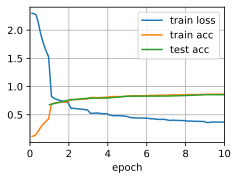

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* AlexNet has a similar structure to that of LeNet, but uses more convolutional layers and a larger parameter space to fit the large-scale dataset ImageNet.
* Today AlexNet has been surpassed by much more effective architectures but it is a key step from shallow to deep networks that are used nowadays.
* Although it seems that there are only a few more lines in AlexNet's implementation than in LeNet, it took the academic community many years to embrace this conceptual change and take advantage of its excellent experimental results. This was also due to the lack of efficient computational tools.
* Dropout, ReLU and preprocessing were the other key steps in achieving excellent performance in computer vision tasks.

## Exercises

1. Try increasing the number of epochs. Compared with LeNet, how are the results different? Why?
1. AlexNet may be too complex for the Fashion-MNIST dataset.
    * Try to simplify the model to make the training faster, while ensuring that the accuracy does not drop significantly.
    * Can you design a better model that works directly on $28 \times 28$ images.
1. Modify the batch size, and observe the changes in accuracy and GPU memory.
1. Rooflines:
    * What is the dominant part for the memory footprint of AlexNet?
    * What is the dominant part for computation in AlexNet?
    * How about memory bandwidth when computing the results?
1. Apply dropout and ReLU to LeNet5. Does it improve? How about preprocessing?


[Discussions](https://discuss.d2l.ai/t/76)